In [116]:
%matplotlib inline

this extension makes it easy to reload the imports without restarting the whole notebook

In [117]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


run this cell if you want to reload the imports (i.e. you changed notebookfns.py)

In [118]:
%autoreload

In [119]:
# these are all standard Python modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

In [120]:
# this is my notebookfns.py file
import notebookfns as n

In [121]:
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('lines', linewidth=3)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)

note that these errors include the weights alpha_1, alpha_2, alpha_3
red is training error, blue is validation error


/home/ryantly3/Homework/M638/Final_Project/notebookfns.py:10: RuntimeWarning: divide by zero encountered in log10
  errors[:, j] = np.log10(errors[:, j])


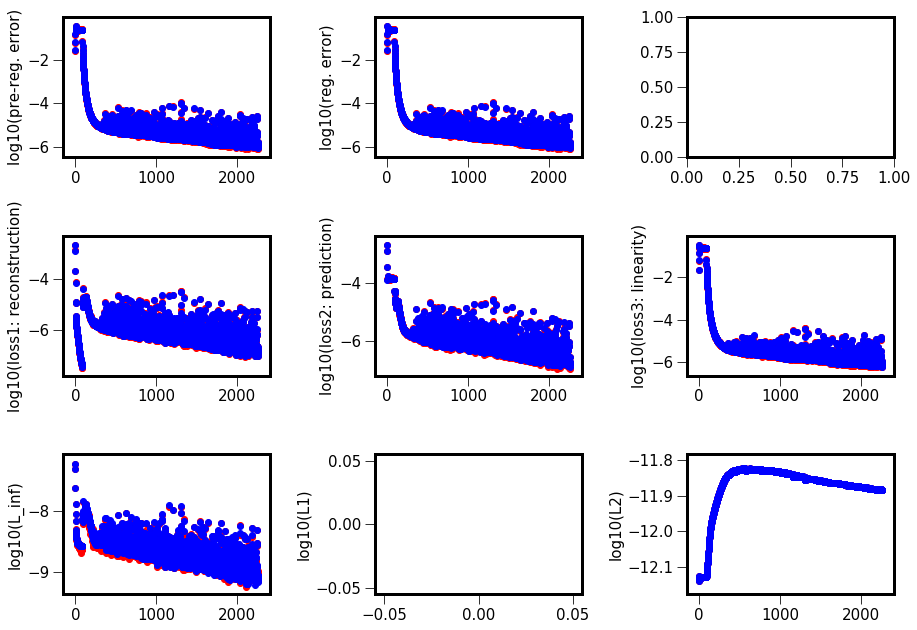

In [122]:
# You can change this filename to point to the pickle file for your model.
# Later code loads the related files (i.e. weights & biases) by changing the end of the filename
fname = './results/Vanderpol_2019_04_26_02_46_47_502477_model.pkl'
errors = np.loadtxt(fname.replace('model.pkl','error.csv'),delimiter=',')
n.PlotErrors(errors, range(0,16))

In [123]:
errors[:,13]

array([-inf, -inf, -inf, ..., -inf, -inf, -inf])

In [124]:
# you may need the encoding part if you save the pickle file in Python 2 and load it in Python 3 
with open(fname, 'rb') as f:
    params = pickle.load(f, encoding='latin1')

Here is just some info that I sometimes found helpful to print 

In [125]:
print('validation error: %.2E' % params['minTest'])

validation error: 8.58E-07


In [126]:
print('We had %d files of training data.' % params['data_train_len'])
print('Length of trajectories: %d steps (goes in Table 2)' % params['len_time'])
print('Batch size: %d (goes in Table 2)' % params['batch_size'])
deltat = params['delta_t']
print('delta_t (time stepping in data): %.3f' % deltat)
T = deltat*(params['len_time']-1)
tSpan = np.linspace(start=0,stop=T,num=params['len_time'],endpoint=True)
print("Time span is %r" % tSpan)

We had 6 files of training data.
Length of trajectories: 51 steps (goes in Table 2)
Batch size: 512 (goes in Table 2)
delta_t (time stepping in data): 0.020
Time span is array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])


In [13]:
print("For Table 4:")
print('log10 of alpha_1 (the weight on losses involving reconstruction): %.1f' % np.log10(params['recon_lam']))
print('log10 of alpha_2 (the weight on L_inf term): %.1f' % np.log10(params['Linf_lam']))
print('log10 of alpha_3 (the weight on L_2 regularization): %.1f' % np.log10(params['L2_lam']))

For Table 4:
log10 of alpha_1 (the weight on losses involving reconstruction): -3.0
log10 of alpha_2 (the weight on L_inf term): -8.0
log10 of alpha_3 (the weight on L_2 regularization): -14.0


In [14]:
print('The training was allowed to run up to %.1f hours' % (params['max_time']/(60*60)))
print('The training actually ran for %.1f hours' % (params['time_exp']/(60*60)))
print('The stop condition was: %s' % params['stop_condition'])

The training was allowed to run up to 6.0 hours
The training actually ran for 4.0 hours
The stop condition was: too slowly improving in first four hours


In [15]:
print('Did we do the autoencoder pre-training? %d' % params['auto_first'])
print('The learning rate was %.2E' % params['learning_rate'])

Did we do the autoencoder pre-training? 1
The learning rate was 1.00E-03


In [16]:
depth = (params['d']-4)/2
print("For Table 3:")
print('The encoder and decoder each had %d hidden layers.' % depth)
print('The widths of the layers of the main network were %r.' % params['widths'])
print('The aux. network had %d hidden layers.' % len(params['hidden_widths_omega']))
print('The widths of the hidden layers of the aux. network were %r.' % params['hidden_widths_omega'])

For Table 3:
The encoder and decoder each had 1 hidden layers.
The widths of the layers of the main network were [2, 140, 2, 2, 140, 2].
The aux. network had 1 hidden layers.
The widths of the hidden layers of the aux. network were [155].


In [17]:
print('We penalized %d (S_p) steps for prediction. (goes in Table 4)' % params['num_shifts'])
print('We penalized %d steps in the linearity loss.' %params['num_shifts_middle'])

We penalized 30 (S_p) steps for prediction. (goes in Table 4)
We penalized 50 steps in the linearity loss.


In [127]:
# load all of the weights and biases into W and b dictionaries
W, b = n.load_weights_koopman(fname, len(params['widths'])-1, len(params['widths_omega_real'])-1, params['num_real'], params['num_complex_pairs'])

In [128]:
# load the validation data
params['data_name'] = 'Vanderpol' # temp fix
X = np.loadtxt('./data/Van_Der_Pol/%s_val_x.csv' % params['data_name'],delimiter=',')

In [129]:
# reshape the validation data
max_shifts_to_stack = n.num_shifts_in_stack(params)
X_stacked, num_traj_val = n.stack_data(X, max_shifts_to_stack, params['len_time'])
print("We used %d trajectories in the validation set." % num_traj_val)
print("Note: accidentally reported in paper that we used more data than we did.")
print("See Pendulum.m: used 5000*.2 = 1000, not 5000")

# Xk is just the initial conditions of each trajectory
Xk = np.squeeze(X_stacked[0,:,:])

We used 1000 trajectories in the validation set.
Note: accidentally reported in paper that we used more data than we did.
See Pendulum.m: used 5000*.2 = 1000, not 5000


In [130]:
# apply the network to just the initial conditions Xk
# output the data transformed to y-coordinates (steps k, k+1, k+2, k+3 are steps 0, 1, 2, 3 here)
# also output the reconstructed Xk and the predictions for three steps
yk, ykplus1, ykplus2, ykplus3, xk_recon, xkplus1, xkplus2, xkplus3 = n.ApplyKoopmanNetOmegas(Xk, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [131]:
# here apply the network to the full dataset
# output list of predictions y and list of encded data g_list, like in the training code
y, g_list = n.ApplyKoopmanNetOmegasFull(X_stacked, W, b, params['delta_t'], params['num_shifts'], params['num_shifts_middle'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [132]:
# calculate the validation loss, split over the loss components
loss1_val, loss2_val, loss3_val, loss_Linf_val, loss_val = n.define_loss(X_stacked, y, g_list, params, W, b)

In [133]:
print('Reconstruction loss (on validation set): %.4E' % loss1_val)
print('Prediction loss (on validation set): %.4E' % loss2_val)
print('Linearity loss (on validation set): %.4E' % loss3_val)
print('L_inf loss (on validation set): %.4E' % loss_Linf_val)
print('Pre-regularization loss (on validation set): %.4E (goes in Table 1)' % loss_val)

Reconstruction loss (on validation set): 9.6885E-08
Prediction loss (on validation set): 1.3609E-07
Linearity loss (on validation set): 6.2476E-07
L_inf loss (on validation set): 6.8801E-10
Pre-regularization loss (on validation set): 8.5843E-07 (goes in Table 1)


In [134]:
loss_L1_val, loss_L2_val, regularized_loss_val = n.define_regularization(params, W, b, loss_val)
print('L1 penalty (on weights): %.4E' % loss_L1_val)
print('L2 penalty (on weights): %.4E' % loss_L2_val)
print('Total regularized loss (on validation set): %.4E' % regularized_loss_val)

L1 penalty (on weights): 0.0000E+00
L2 penalty (on weights): 1.3070E-12
Total regularized loss (on validation set): 8.5843E-07


In [135]:
print('Sanity check:')
print('Compare to validation loss recorded during training: %.4E' % params['minTest'])
print('Compare to regularized validation loss recorded during training: %.4E' %params['minRegTest'])

Sanity check:
Compare to validation loss recorded during training: 8.5843E-07
Compare to regularized validation loss recorded during training: 8.5843E-07


In [136]:
# apply the auxiliary network to the encoded data
omegas = n.omega_net_apply(yk, W, b, params['num_real'], params['num_complex_pairs'], params['num_omega_weights'])

In [137]:
# The auxiliary network outputs the parameters for the eigenvalues in the K matrix.
# For each pair of complex conjugate eigenvalues, the continuous time version would be lambda = mu +/- i omega
# The discrete time version is exp(lambda delta t) 
# By Euler's formula, can also write this as exp(mu deltat) * (cos(omega deltat) + i sin(omega deltat))
# The auxiliary network outputs mu and omega
print('Omega ranges from %.3f to %.3f (corresponding to changing frequencies)' % (np.min(omegas[0][:,0]), np.max(omegas[0][:,0])))
print('Mu ranges from %.6f to %.6f (so there is almost no growth or decay)' % (np.min(omegas[0][:,1]), np.max(omegas[0][:,1])))
print('Recall: delta_t = %.2f' % deltat) 

Omega ranges from 0.951 to 1.006 (corresponding to changing frequencies)
Mu ranges from -0.151162 to 0.045614 (so there is almost no growth or decay)
Recall: delta_t = 0.02


In [138]:
print('To set axis ticks on next two figures:')
print('The first y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,0]), np.max(yk[:,0])))
print('The second y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,1]), np.max(yk[:,1])))

To set axis ticks on next two figures:
The first y coordinate ranges from -0.144 to 0.142.
The second y coordinate ranges from -0.215 to 0.213.


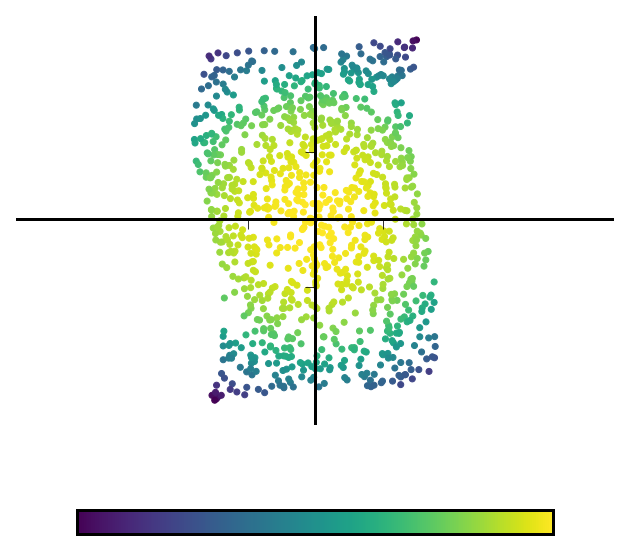

In [145]:
# Supplementary Figure 4
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)
sc = ax.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[0][:,0]))
CBI = plt.colorbar(sc, orientation='horizontal', shrink=.8, ticks = [-.4, -.95])
CBI.ax.set_xticklabels(['-4','-0.95'])

xlab = [-.08,0,.08]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.08, 0, .08]
plt.yticks(ylab, xlabels)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.axis('equal')

#plt.savefig('PendulumEvals1.svg', dpi=200, transparent=True)
plt.show()

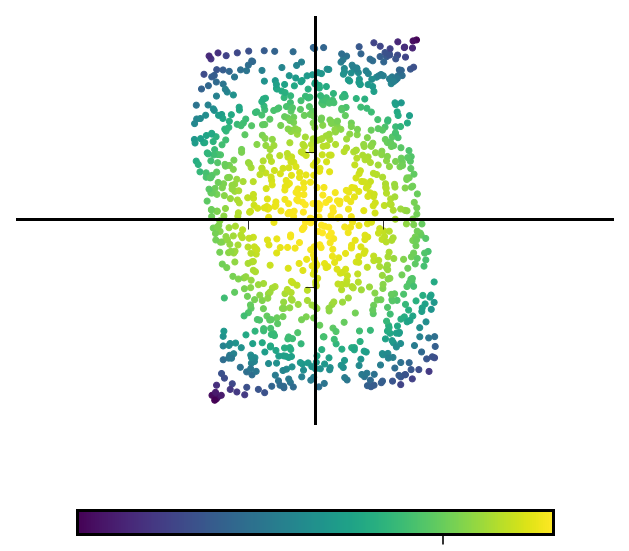

In [32]:
# Supplementary Figure 4
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)
sc = ax.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[0][:,1]))
CBI = plt.colorbar(sc, orientation='horizontal', shrink=.8, ticks = [-.0002, 0.0002])
CBI.ax.set_xticklabels(['',''])

xlab = [-.08,0,.08]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.08, 0, .08]
plt.yticks(ylab, xlabels)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.axis('equal')

plt.savefig('PendulumEvals2.svg', dpi=200, transparent=True)
plt.show()

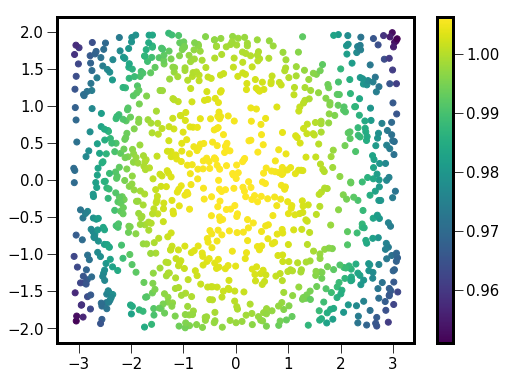

In [33]:
plt.figure(figsize=(8,6))
colors = np.asarray(omegas[0][:,0])[:,0]
plt.scatter(np.asarray(Xk[:,0]), np.asarray(Xk[:,1]), c=colors)
plt.colorbar()

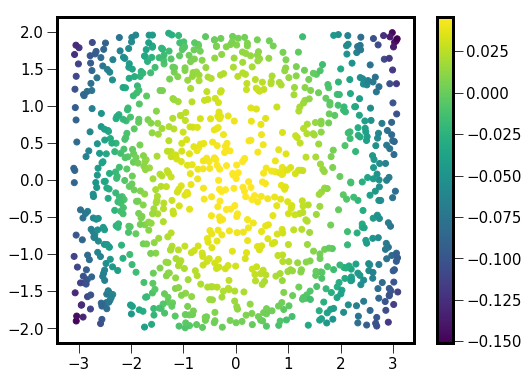

In [34]:
plt.figure(figsize=(8,6))
colors = np.asarray(omegas[0][:,1])[:,0]
plt.scatter(np.asarray(Xk[:,0]), np.asarray(Xk[:,1]), c=colors)
plt.colorbar()

In [35]:
print('Reconstruction error on initial conditions: %.2E' % np.mean(np.square(Xk - xk_recon)))
print('1-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:]))))
print('2-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:]))))

Reconstruction error on initial conditions: 9.69E-05
1-step prediction error on initial conditions: 8.90E-05
2-step prediction error on initial conditions: 8.46E-05


In [36]:
print('Relative reconstruction error on initial conditions: %.2E' % (np.mean(np.square(Xk - xk_recon))/np.mean(np.square(Xk))))
print('Relative 1-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:])))/np.mean(np.square(np.squeeze(X_stacked[1,:,:])))))
print('Relative 2-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:])))/np.mean(np.square(np.squeeze(X_stacked[2,:,:])))))

Relative reconstruction error on initial conditions: 4.28E-05
Relative 1-step prediction error on initial conditions: 3.94E-05
Relative 2-step prediction error on initial conditions: 3.76E-05


In [106]:
data = Xk.copy()

In [107]:
# For other plots, it's helpful to consider a full grid of input data
# Create a mesh grid and reshape it
xvals = np.linspace(-3.1,3.1,300)
yvals = np.linspace(np.min(data[:,1]),np.max(data[:,1]),300)
X, Y = np.meshgrid(xvals, yvals)

grid = np.zeros((90000,2))
grid[:,0] = np.reshape(X, (90000,))
grid[:,1] = np.reshape(Y, (90000,))
print(grid.shape)

(90000, 2)


In [108]:
# Apply the network to the whole grid
grid_yk, grid_ykplus1, grid_ykplus2, grid_ykplus3, grid_xk_recon, grid_xkplus1, grid_xkplus2, grid_xkplus3 = n.ApplyKoopmanNetOmegas(grid, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [109]:
grid_reshaped0 = grid_yk[:,0].reshape(300,300)
grid_reshaped1 = grid_yk[:,1].reshape(300,300)

In [111]:
grid_yk[:,0]

matrix([[ 0.12635759],
        [ 0.12610885],
        [ 0.12586012],
        ...,
        [-0.12398431],
        [-0.124365  ],
        [-0.12474569]])

In [38]:
# Potential function for the pendulum (for plotting purposes)
def potential(x,y):
    pot = (1.0/2.0)*(y**2) -np.cos(x)
    return pot

In [39]:
# Don't want to plot data with too high of potential energy (outside of our training data) 
# where the period goes to infinity
# Instead of plotting rectangle of data, just plot our region of interest, where the pendulum system is well-behaved
for i in range(grid_reshaped0.shape[0]):
    for j in range(grid_reshaped0.shape[1]):
        if (potential(X[i,j],Y[i,j]) > .99):
            grid_reshaped0[i,j] = float('nan')
            grid_reshaped1[i,j] = float('nan')

In [40]:
# Nice to draw a black outline
outline_x = np.linspace(-np.pi, np.pi, 2000)
outline_y1 = np.sqrt(2*.99 + 2*np.cos(outline_x))
outline_y2 = -np.sqrt(2*.99 + 2*np.cos(outline_x))

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


Eigenfunction ranges in magnitude from 0.000000 to 0.008813
[0.     0.0015 0.003  0.0045 0.006  0.0075]


<Figure size 432x288 with 0 Axes>

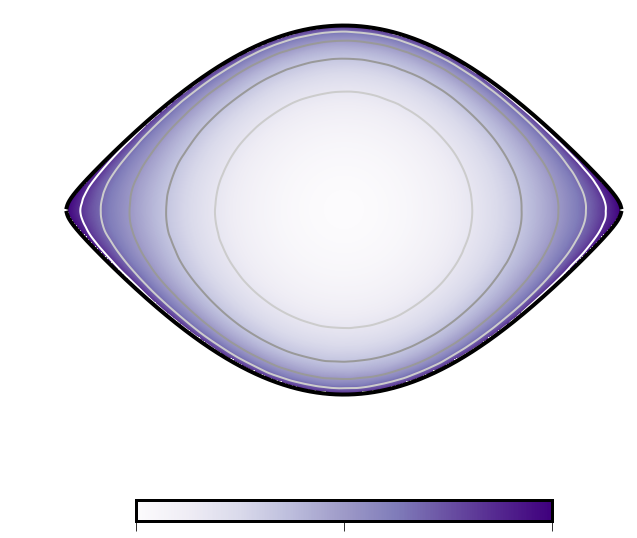

In [41]:
# Figure 5
# calculate the magnitude (coloring in this figure)
efn_magnitude = np.square(grid_reshaped0) + np.square(grid_reshaped1)
print('Eigenfunction ranges in magnitude from %.6f to %.6f' % (np.nanmin(efn_magnitude), np.nanmax(efn_magnitude)))

n.EigenfunctionPlot('Purples', efn_magnitude, outline_x, outline_y1, 
                    outline_x, outline_y2, X, Y, 
                    filename='MagnitudeEigenfunction.png', cbFlag=True, 
                    levels = np.arange(0, .009, .0015), cbTicks = [0, 0.0044, .0088])

Ranges in phase from -3.141566 to 3.141544
[-4, 4]


/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


<Figure size 432x288 with 0 Axes>

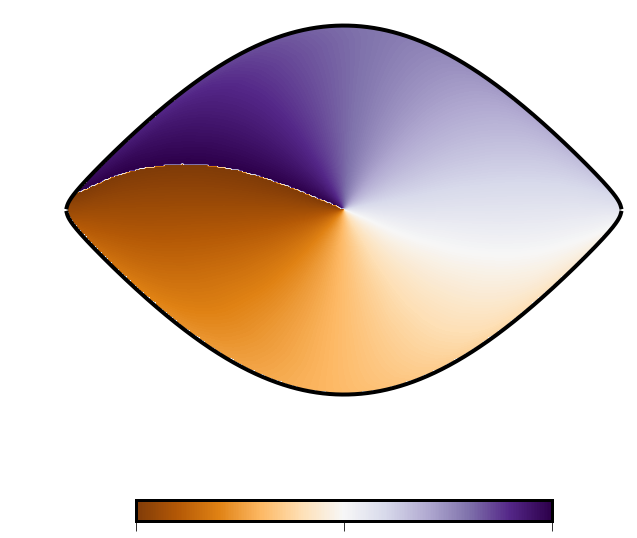

In [42]:
# Figure 5
# calculate the phase (coloring in this figure)
efn_phase = np.arctan2(grid_reshaped1,grid_reshaped0)
print('Ranges in phase from %.6f to %.6f' % (np.nanmin(efn_phase), np.nanmax(efn_phase)))

n.EigenfunctionPlot('PuOr',efn_phase, outline_x, outline_y1, outline_x, 
                    outline_y2, X, Y, filename='PhaseEigenfunction.png', cbFlag=True, 
                    levels=[-4,4], cbTicks=[-3.14,0,3.14])

In [43]:
# calculate range of eigenfunction value in order to make colormap good and choose good levels to plot
efns_min = np.nanmin(grid_yk)
efns_max = np.nanmax(grid_yk)
print('1st eigenfunction ranges from %.4f to %.4f' % (efns_min, efns_max))

1st eigenfunction ranges from -0.0924 to 0.0920


[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02
  8.00000000e-02]


<Figure size 432x288 with 0 Axes>

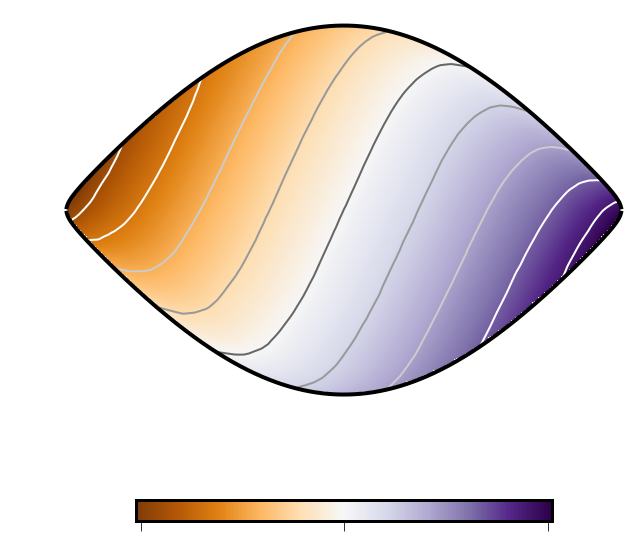

In [44]:
# Figure 4e
n.EigenfunctionPlot('PuOr',grid_reshaped0, outline_x, outline_y1, outline_x, 
                    outline_y2, X, Y, filename='Eigenfunction1.png', 
                    levels=np.arange(-.08,.09,.02), cbTicks=[-.09,0,.09],climits=[efns_min,efns_max])

In [45]:
print('2nd eigenfunction ranges from %.4f to %.4f' % (np.nanmin(grid_reshaped1), np.nanmax(grid_reshaped1)))

2nd eigenfunction ranges from -0.0878 to 0.0882


[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02
  8.00000000e-02]


<Figure size 432x288 with 0 Axes>

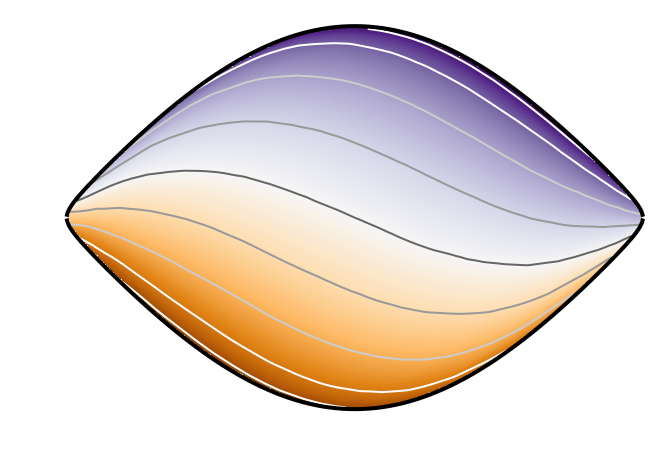

In [46]:
# Second part of Figure 4e
n.EigenfunctionPlot('PuOr',grid_reshaped1, outline_x, outline_y1, outline_x, 
                    outline_y2, X, Y, filename='Eigenfunction2.png', 
                    cbFlag=False, levels=np.arange(-.08,.09,.02),climits=[efns_min,efns_max])

In [47]:
# Load some nice evenly spaced rings that are good for plotting
rings = np.loadtxt('PendulumRings.csv', delimiter=',')

# newShape = rings.shape[0], rings.shape[1]/2, 2
rings  = rings.reshape((rings.shape[0],int(rings.shape[1]/2), 2))

In [48]:
# I wrote a function that calculates the frequency at a given point (convenient for plotting)
import CalculateFrequency as cf

In [49]:
# We're going to plot some trajectories (rings) in pendulum phase space. 
# Each one corresponds to an evenly spaced initial condition.
# Here, for convenience, we calculate the period of each trajectory. 
tol = 10**(-7)
maxN = 400
T = 30
deltat = .02
tSpan = np.arange(0, T, deltat)
numPoints = len(tSpan)

theta0opts = np.linspace(-np.pi, 0, 12)
theta0opts = theta0opts[1:-1]
T = 30
periods = np.zeros((len(theta0opts),1))
for j in np.arange(len(theta0opts)):
    theta0 = theta0opts[j]
    periods[j] = cf.periodPendulum(theta0, tol, maxN)

In [50]:
from matplotlib.colors import LinearSegmentedColormap

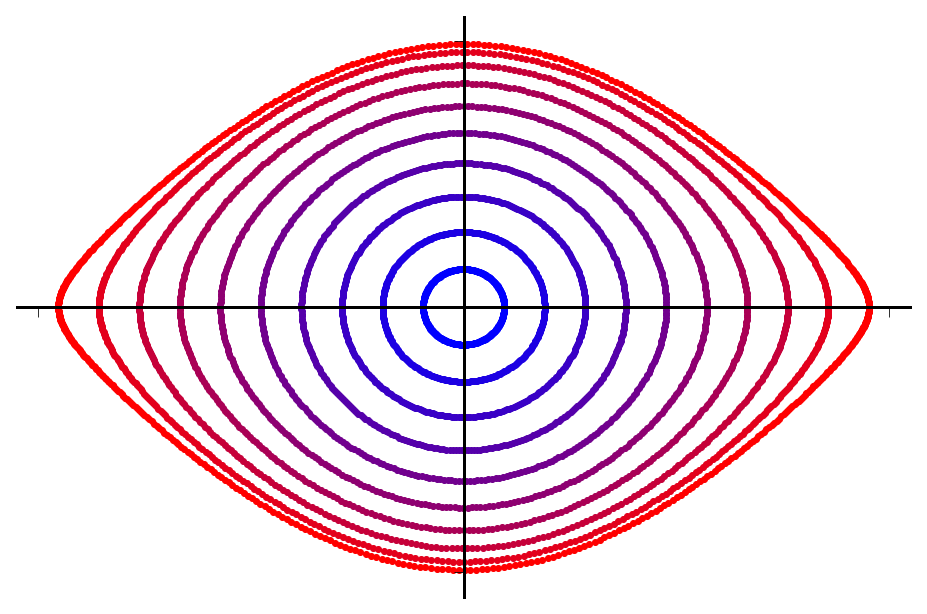

In [51]:
# This is almost part of Figure 4a, but Figure 4a has lines instead of a scatter plot
# create a special color map that ranges red -> purple -> blue
colors = [(1, 0, 0), (.5, 0, .5), (0, 0, 1)]
mymap = LinearSegmentedColormap.from_list('red_purple_blue', colors, N=10)

# here, just plot the trajectories (rings)
# they look nicer if you don't overlap points, so we stop at the period
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16)
fig.set_figheight(16/3*2)

for j in np.arange(len(theta0opts)):
    inds = np.nonzero(tSpan <= periods[j])
    ind = np.max(inds)+1
    plt.scatter(rings[j,:ind,0],rings[j,:ind,1], color=mymap(j))
xlab = [-3,0,3]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-2,0,2]
ylabels = ''
plt.yticks(ylab,ylabels)
#plt.axis('off')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
#plt.savefig('PendulumEye.pdf', dpi=200, transparent=True)

In [52]:
rings_yk = np.zeros(rings.shape)
rings_yk_transform = np.zeros(rings.shape,dtype=np.complex64)
rings_recon = np.zeros(rings.shape)
rings_pred = np.zeros(rings.shape)
rings_lambdas = np.zeros(rings.shape,dtype=np.complex64)

print('Eigenvalues for each traj. Note: real part about constant, but the imaginary part drifts.')
for j in np.arange(rings.shape[0]):
    traj = np.squeeze(rings[j,:,:])

    lenTtraj = len(traj)
    
    # apply the network to each trajectory (ring)
    traj_yk, traj_ykplus1, traj_ykplus2, traj_ykplus3, traj_xk_recon, traj_xkplus1, traj_xkplus2, traj_xkplus3 = n.ApplyKoopmanNetOmegas(traj, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])
    # apply the auxiliary network to each one
    omegas_traj = n.omega_net_apply(traj_yk, W, b, params['num_real'], params['num_complex_pairs'], params['num_omega_weights'])
    
    rings_yk[j,:,:] = traj_yk.copy()
    rings_recon[j,:,:] = traj_xk_recon.copy()
    rings_pred[j,:,:] = traj_xkplus1.copy()
    
    # what's the average omega (real part of eigenvalue) for this trajectory?
    # (note that for this system, we expect this to be constant along trajectories)
    omega_av_traj = np.mean(omegas_traj[0])

    # create 2x2 K matrix with this omega
    L_approx_traj = np.asmatrix([[np.cos(omega_av_traj*deltat), np.sin(omega_av_traj*deltat)], [-np.sin(omega_av_traj*deltat), np.cos(omega_av_traj*deltat)]])
    # calculate the eigenvalues
    # note that this is the discrete case: exp(lambda * deltat) if lambda is the eigenvalue in the continuous case
    evals_net, T_net = np.linalg.eig(L_approx_traj)
    print(evals_net)

    # calculate eval^k for k = 0, 1, ....
    # should match if really have linear system
    for k in np.arange(lenTtraj-1):
        for l in np.arange(len(evals_net)):
            rings_lambdas[j,k,l] = np.power(evals_net[l],k)
    
    # trajectory was mapped into y coordinates
    # now multiply by eigenvector matrix (diagonaliation)
    yk_net_traj_transform = np.asarray(traj_yk*T_net)
    rings_yk_transform[j,:,:] = yk_net_traj_transform.copy()

    

Eigenvalues for each traj. Note: real part about constant, but the imaginary part drifts.
[0.99998902+0.00468538j 0.99998902-0.00468538j]
[0.99998286+0.005855j 0.99998286-0.005855j]
[0.99997702+0.00677896j 0.99997702-0.00677896j]
[0.99997155+0.00754267j 0.99997155-0.00754267j]
[0.99996639+0.00819836j 0.99996639-0.00819836j]
[0.99996179+0.00874217j 0.99996179-0.00874217j]
[0.99995793+0.00917282j 0.99995793-0.00917282j]
[0.99995492+0.0094952j 0.99995492-0.0094952j]
[0.99995281+0.00971438j 0.99995281-0.00971438j]
[0.99995158+0.00984013j 0.99995158-0.00984013j]


In [53]:
# in order to pick good places for ticks on the axes
print('x-values of rings range from %.3f to %.3f' % (np.min(rings_yk[:,:,0]), np.max(rings_yk[:,:,0])))
print('y-values of rings range from %.3f to %.3f' % (np.min(rings_yk[:,:,1]), np.max(rings_yk[:,:,1])))

x-values of rings range from -0.086 to 0.087
y-values of rings range from -0.085 to 0.085


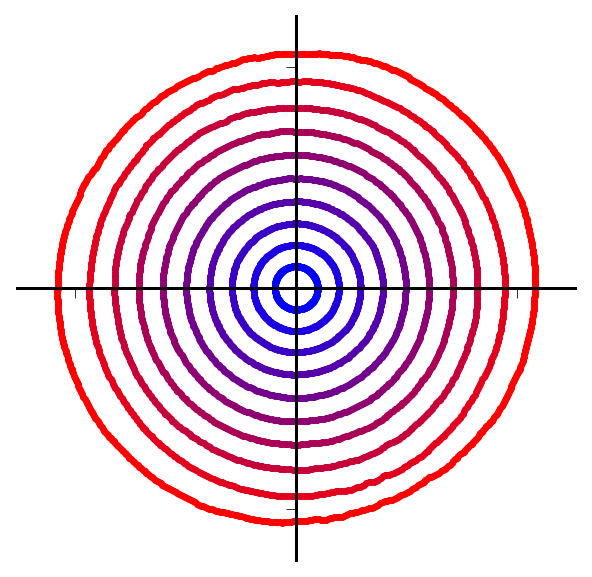

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(10)
fig.set_figheight(10)

for j in np.arange(rings.shape[0]):
    # again, stop when reach one period
    inds = np.nonzero(tSpan <= periods[j])
    ind = np.max(inds)+1
    plt.scatter(np.array(rings_yk[j,:ind,0]),np.array(rings_yk[j,:ind,1]), color=mymap(j))


xlab = [-.08,0,.08]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.08,0,.08]
ylabels = ''
plt.yticks(ylab,ylabels)

plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.savefig('PendulumLinear.svg', dpi=200, transparent=True)


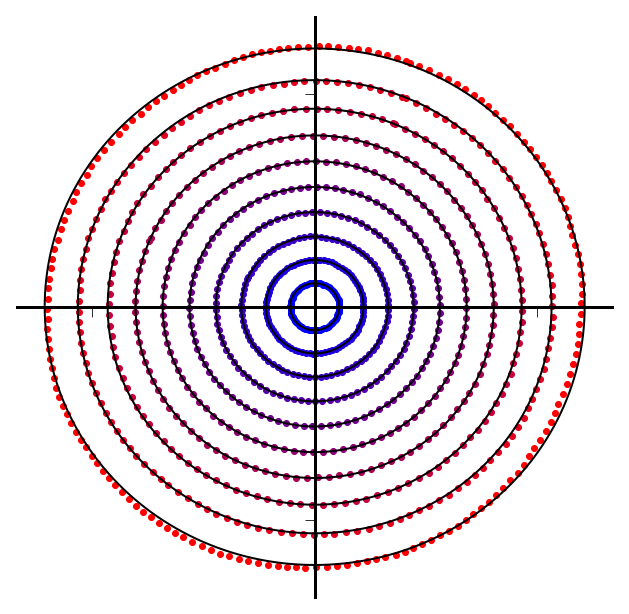

In [55]:
# Figure 4d
# to check if really linear, 
# compare eval^k (k = 0, 1, ...) to the transformed and normalized y-coordinates
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)

for j in np.arange(rings.shape[0]):
    inds = np.nonzero(tSpan <= periods[j])
    ind = np.max(inds)+1
    subset = np.arange(0,ind,4)

    scale = np.mean(np.abs(rings_yk_transform[j,:,0]))
    
    ind_pos = np.nonzero(rings[j,:ind,1] >= 0)[0]
    ind_neg = np.nonzero(rings[j,:ind,1] < 0)[0]
    
    plt.plot(np.array(np.real(rings_lambdas[j,:ind,0]*scale)), np.array(np.imag(rings_lambdas[j,:ind,0]*scale)), 'k', linewidth=2)
    plt.plot(np.array(np.real(rings_lambdas[j,:ind,0]*scale)), np.array(np.imag(rings_lambdas[j,:ind,1]*scale)), 'k', linewidth=2)
    ax.scatter(np.array(np.real(rings_yk_transform[j,subset,0])),np.array(np.imag(rings_yk_transform[j,subset,0])), color=mymap(j))


xlab = [-.05,0,.05]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.05,0,.05]
ylabels = ''
plt.yticks(ylab,ylabels)
#plt.axis('off')
#plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.savefig('PendulumLinear.svg', dpi=200, transparent=True)


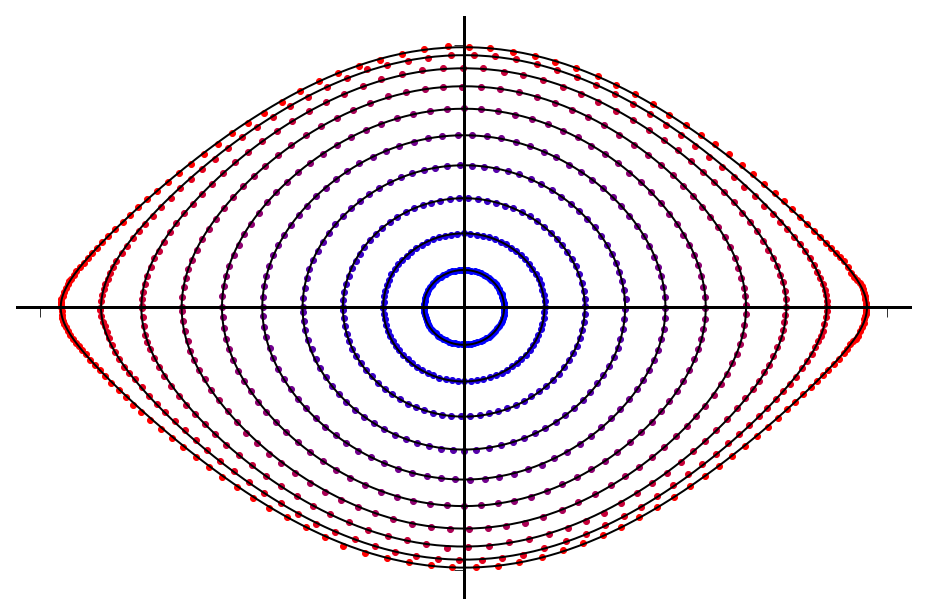

In [56]:
# Figure 4b
# plot reconstruction error
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)

for j in np.arange(rings.shape[0]):
    
    inds = np.nonzero(tSpan <= periods[j])
    ind = np.max(inds)+1
    subset = np.arange(0,ind,4)

    ind_pos = np.nonzero(rings[j,:ind,1] >= 0)[0]
    ind_neg = np.nonzero(rings[j,:ind,1] < 0)[0]
    plt.plot(np.array(rings[j,ind_pos,0]), np.array(rings[j,ind_pos,1]), 'k', linewidth=2)
    plt.plot(np.array(rings[j,ind_neg,0]), np.array(rings[j,ind_neg,1]), 'k', linewidth=2)
    plt.scatter(np.array(rings_recon[j,subset,0]),np.array(rings_recon[j,subset,1]), color=mymap(j))


xlab = [-3,0,3]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-2,0,2]
ylabels = ''
plt.yticks(ylab,ylabels)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

fig.savefig('PendulumRecon.svg', dpi=200, transparent=True)


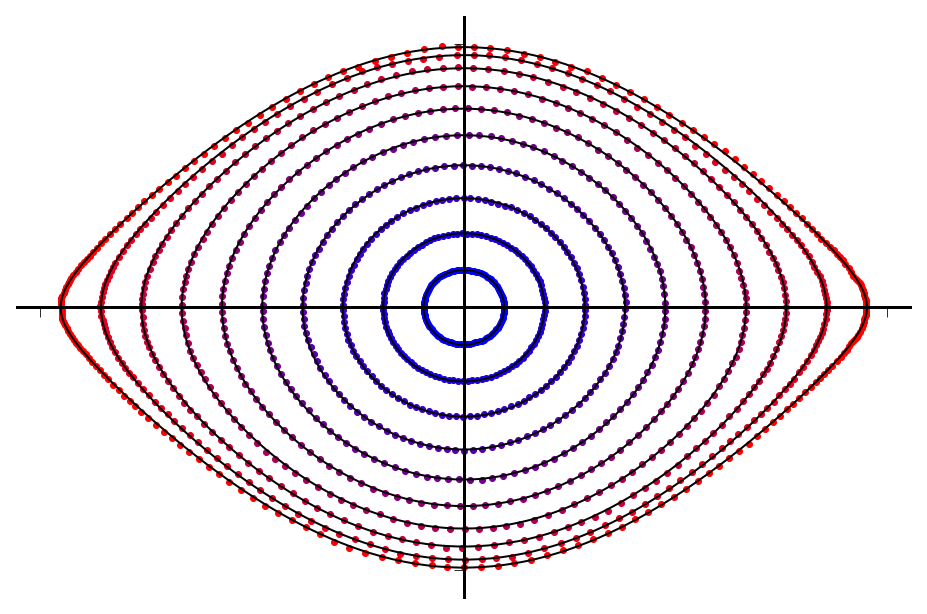

In [57]:
# plot 1-step prediction error
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16)
fig.set_figheight(16/3*2)

for j in np.arange(rings.shape[0]):
    inds = np.nonzero(tSpan <= periods[j])
    ind = np.max(inds)+1
    subset = np.arange(0,ind,3)
    ind_pos = np.nonzero(rings[j,:ind,1] >= 0)[0]
    ind_neg = np.nonzero(rings[j,:ind,1] < 0)[0]
    plt.plot(np.array(rings[j,ind_pos,0]), np.array(rings[j,ind_pos,1]), 'k', linewidth=2)
    plt.plot(np.array(rings[j,ind_neg,0]), np.array(rings[j,ind_neg,1]), 'k', linewidth=2)
    plt.scatter(np.array(rings_pred[j,subset,0]),np.array(rings_pred[j,subset,1]), color=mymap(j))


xlab = [-3,0,3]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-2,0,2]
ylabels = ''
plt.yticks(ylab,ylabels)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
#fig.savefig('PendulumPred.svg', dpi=200, transparent=True)

In [58]:
# now apply network to these trajectories again, but this time for many steps
# this time, only network initial condition of each trajectory.
rings_long_pred = np.zeros(rings.shape)

num_steps = rings.shape[1]-1
omega_ic = np.zeros((1,1))

for j in np.arange(rings.shape[0]):
    ic = np.squeeze(rings[j,0,:])
    rings_long_pred[j,0,:] = ic
    rings_long_pred[j,1:,:] = n.PredictKoopmanNetOmegas(ic, W, b, deltat, num_steps, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


trajectory 0: worst rel. error 0.421
	first ind with error > 10p: 480 of 1500 (one period is 670 steps)
trajectory 1: worst rel. error 0.265
	first ind with error > 10p: 887 of 1500 (one period is 538 steps)
trajectory 2: worst rel. error 0.152
	first ind with error > 10p: 1237 of 1500 (one period is 465 steps)
trajectory 3: worst rel. error 0.076
trajectory 4: worst rel. error 0.081
trajectory 5: worst rel. error 0.050
trajectory 6: worst rel. error 0.050
trajectory 7: worst rel. error 0.136
	first ind with error > 10p: 1096 of 1500 (one period is 330 steps)
trajectory 8: worst rel. error 0.228
	first ind with error > 10p: 668 of 1500 (one period is 321 steps)
trajectory 9: worst rel. error 0.319
	first ind with error > 10p: 484 of 1500 (one period is 316 steps)


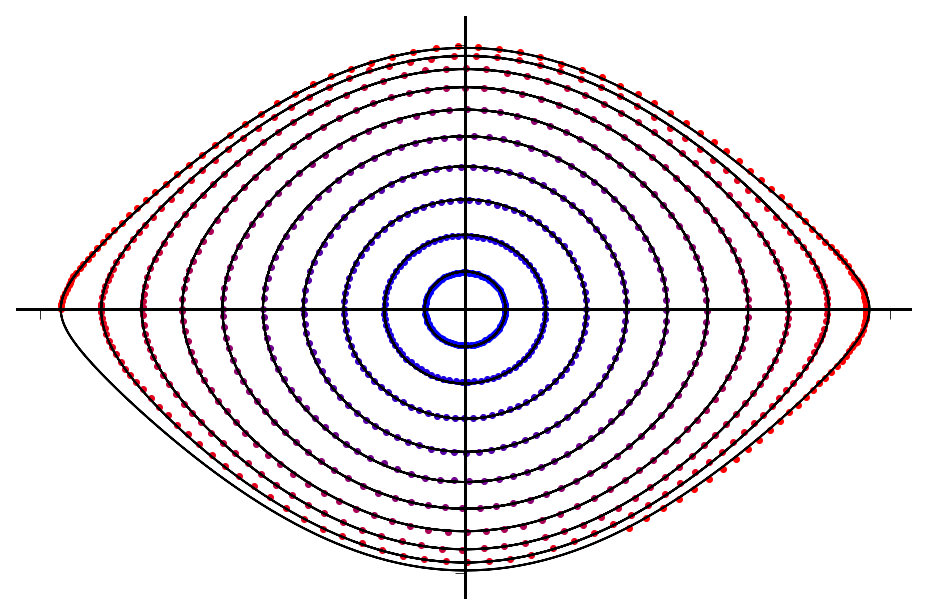

In [59]:
# Figure 4c
# plot long-term prediction:
# if only give network initial condition, then have network predict many steps, how long is it accurate?
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)

for j in np.arange(rings.shape[0]):
    inds = np.nonzero(tSpan <= periods[j])
    ind = np.max(inds)+1
    
    temp = rings[j,:,:].copy()
    plt.plot(temp[:,0],temp[:,1], 'k', linewidth=2)
    temp2 = rings_long_pred[j,:,:].copy()
    
    diffs = np.linalg.norm(temp - temp2,ord=2,axis=1)

    normalize = np.linalg.norm(temp,ord=2,axis=1)
    relerr = diffs/normalize
    print("trajectory %d: worst rel. error %.3f" % (j, np.max(relerr)))
    indBigErr = np.nonzero(relerr > .1) # 10% error 
    if len(indBigErr[0]) > 0:
        print("\tfirst ind with error > 10p: %d of %d (one period is %d steps)"  % (indBigErr[0][0], rings.shape[1], ind))
        indEnd = np.minimum(ind, indBigErr[0][0])
    else:
        indEnd = ind
    subset = np.arange(0,indEnd, 4)
    plt.scatter(temp2[subset,0],temp2[subset,1],color=mymap(j))

xlab = [-3,0,3]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-2,0,2]
ylabels = ''
plt.yticks(ylab,ylabels)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

fig.savefig('PendulumLongPrediction.svg', dpi=200, transparent=True)

In [60]:
# shape: num_examples, num_steps, n
# send initial conditions through network again, but predict many steps (50)
print('We now predict the initial conditions %d steps forward' % max_shifts_to_stack)
long_pred_Xk = n.PredictKoopmanNetOmegas(Xk, W, b, deltat, max_shifts_to_stack, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


We now predict the initial conditions 50 steps forward


In [61]:
# how does prediction error change with the number of prediction steps?
# we expect it to accumulate error, but hopefully not too fast
long_pred_error = np.zeros((max_shifts_to_stack, ))
for j in np.arange(max_shifts_to_stack):
    long_pred_error[j] = np.mean(np.mean(np.square(long_pred_Xk[:,j,:] - X_stacked[j+1,:,:]), axis=0)) 

In [62]:
# so we can put ticks in good places
print('log10 error ranges from %.2f to %.2f' % (min(np.log10(long_pred_error)), max(np.log10(long_pred_error))))

log10 error ranges from -4.76 to -4.09


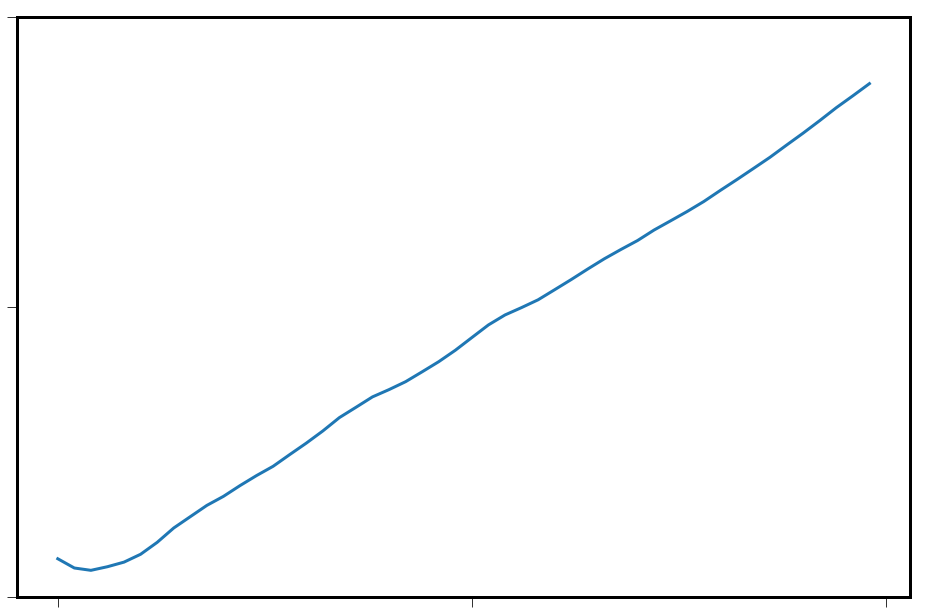

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16)
fig.set_figheight(16/3*2)

plt.plot(np.arange(max_shifts_to_stack), np.log10(long_pred_error), linewidth=3)

xlab = [0,max_shifts_to_stack/2,max_shifts_to_stack]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-4.0,-4.4,-4.8]
ylabels = ''
plt.yticks(ylab,ylabels)
fig.savefig('PendulumPredOverSteps.svg', dpi=200, transparent=True)

In [64]:
# moved this to the bottom because it's so slow
loss1_train, loss2_train, loss3_train, loss_Linf_train, loss_train, regularized_loss_train, total_num_traj = n.loss_training(params, max_shifts_to_stack, W, b)
print("# training traj: %d (goes in Table 2)" % total_num_traj)
print("Note: accidentally reported in paper that we used more data than we did.")
print("See Pendulum.m: used 5000*.7 = 3500 per file, not 5000")

file 1 has 3500 trajectories
file 2 has 3500 trajectories
file 3 has 3500 trajectories
# training traj: 10500 (goes in Table 2)
Note: accidentally reported in paper that we used more data than we did.
See Pendulum.m: used 5000*.7 = 3500 per file, not 5000


In [65]:
print('Reconstruction loss (on train set): %.4E' % loss1_train)
print('Prediction loss (on train set): %.4E' % loss2_train)
print('Linearity loss (on train set): %.4E' % loss3_train)
print('L_inf loss (on train set): %.4E' % loss_Linf_train)
print('Pre-regularization loss (on train set): %.4E (goes in Table 1)' % loss_train)
print('Total regularized loss (on train set): %.4E' % regularized_loss_train)

Reconstruction loss (on train set): 1.7374E-08
Prediction loss (on train set): 2.3625E-08
Linearity loss (on train set): 4.4138E-08
L_inf loss (on train set): 4.4965E-11
Pre-regularization loss (on train set): 8.5183E-08 (goes in Table 1)
Total regularized loss (on train set): 8.5186E-08


# Test error

DO NOT CALCULATE UNTIL READY TO REPORT FINAL RESULTS

In [66]:
## We decided to report this example in the paper, so now we can calcuate test errror
#loss1_test, loss2_test, loss3_test, loss_Linf_test, loss_test, regularized_loss_test = n.loss_test(params, max_shifts_to_stack, W, b)
#print("Note: accidentally reported in paper that we used more data than we did.")
#print("See Pendulum.m: used 5000*.1 = 500 for testing, not 5000")

test file has 500 trajectories
Note: accidentally reported in paper that we used more data than we did.
See Pendulum.m: used 5000*.1 = 500 for testing, not 5000


In [67]:
#print('Reconstruction loss (on test set): %.4E' % loss1_test)
#print('Prediction loss (on test set): %.4E' % loss2_test)
#print('Linearity loss (on test set): %.4E' % loss3_test)
#print('L_inf loss (on test set): %.4E' % loss_Linf_test)
#print('Pre-regularization loss (on test set): %.4E (goes in Table 1)' % loss_test)
#print('Total regularized loss (on test set): %.4E' % regularized_loss_test)

Reconstruction loss (on test set): 1.9286E-08
Prediction loss (on test set): 2.8859E-08
Linearity loss (on test set): 6.5222E-08
L_inf loss (on test set): 3.6841E-11
Pre-regularization loss (on test set): 1.1340E-07 (goes in Table 1)
Total regularized loss (on test set): 1.1341E-07


In [68]:
#print("Could be that error would be higher on larger test set, so try larger one.")
#print("Check test error on larger test set:")
#loss1_testextra, loss2_testextra, loss3_testextra, loss_Linf_testextra, loss_testextra, regularized_loss_testextra = n.loss_test(params, max_shifts_to_stack, W, b, suffix='testextra')
#print('Reconstruction loss (on larger test set): %.4E' % loss1_testextra)
#print('Prediction loss (on larger test set): %.4E' % loss2_testextra)
#print('Linearity loss (on larger test set): %.4E' % loss3_testextra)
#print('L_inf loss (on larger test set): %.4E' % loss_Linf_testextra)
#print('Pre-regularization loss (on larger test set): %.4E (compare to numbers in Table 1)' % loss_testextra)
#print('Total regularized loss (on larger test set): %.4E' % regularized_loss_testextra)

Could be that error would be higher on larger test set, so try larger one.
Check test error on larger test set:
test file has 5000 trajectories
Reconstruction loss (on larger test set): 1.7878E-08
Prediction loss (on larger test set): 2.4776E-08
Linearity loss (on larger test set): 5.1348E-08
L_inf loss (on larger test set): 4.4609E-11
Pre-regularization loss (on larger test set): 9.4047E-08 (compare to numbers in Table 1)
Total regularized loss (on larger test set): 9.4050E-08


In [69]:
#print("Good news: error even lower on larger test set, and matches validation error!")

Good news: error even lower on larger test set, and matches validation error!
